In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, concatenate
import scipy
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve
from tensorflow.keras.optimizers import Adam
import random
import itertools
import csv
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
notes = pd.read_csv('/content/patient_notes.csv')

notes = notes.drop(columns=['hadm_id','chartdate','category'])

notes = notes.groupby('subject_id').agg({'text': ' '.join, 'mortality': 'first'}).reset_index()

stop_words = set(stopwords.words('english'))
for i in range(len(notes)):
  s = notes['text'][i]
  # lowercasing
  s = s.lower()
  # remove punctuation
  s = re.sub(r'[^\w\s]', '', s)
  # remove stopwords
  s = ' '.join([word for word in s.split() if word not in stop_words])
  notes['text'][i] = s

In [4]:
test_ids = pd.read_csv('/content/demo_xgb.csv')

# split the data
train = notes[~notes['subject_id'].isin(test_ids['ID'])]
test = notes[notes['subject_id'].isin(test_ids['ID'])]

In [5]:
# preprocess the text data and compute the TF-IDF features
vectorizer = TfidfVectorizer()

# train
X_train = vectorizer.fit_transform(train['text'])
y_train = np.array(train['mortality'])

# test
X_test = vectorizer.transform(test['text'])
y_test = np.array(test['mortality'])

In [6]:
# initialize the undersampler
undersampler = RandomUnderSampler(random_state=19437278)
# apply undersampling to the training set
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

In [7]:
X_train_dense = X_train_resampled.toarray()  # convert to dense array
X_test_dense = X_test.toarray()

# reshape the data for the CNN input
X_train_reshaped = X_train_dense.reshape((X_train_dense.shape[0], X_train_dense.shape[1], 1))
X_test_reshaped = X_test_dense.reshape((X_test_dense.shape[0], X_test_dense.shape[1], 1))

In [8]:
'''param_space = {
    'num_filters': [32, 64, 128],
    'kernel_size': [3, 5, 7],
    'activation': ['relu', 'tanh'],
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.3, 0.5, 0.7]
}'''

"param_space = {\n    'num_filters': [32, 64, 128],\n    'kernel_size': [3, 5, 7],\n    'activation': ['relu', 'tanh'],\n    'optimizer': ['adam', 'rmsprop'],\n    'dropout_rate': [0.3, 0.5, 0.7]\n}"

In [8]:
# sample input shape (replace with your actual data shape)
input_shape = (X_train_reshaped.shape[1], 1)

In [10]:
'''def create_compile_model(num_filters, kernel_size, activation, optimizer, dropout_rate):
    model = Sequential([
        Conv1D(filters=num_filters, kernel_size=kernel_size, activation=activation, input_shape=(X_train_reshaped.shape[1], 1)),
        MaxPooling1D(2),
        Flatten(),
        Dense(10, activation=activation),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model'''

"def create_compile_model(num_filters, kernel_size, activation, optimizer, dropout_rate):\n    model = Sequential([\n        Conv1D(filters=num_filters, kernel_size=kernel_size, activation=activation, input_shape=(X_train_reshaped.shape[1], 1)),\n        MaxPooling1D(2),\n        Flatten(),\n        Dense(10, activation=activation),\n        Dropout(dropout_rate),\n        Dense(1, activation='sigmoid')\n    ])\n    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])\n    return model"

In [9]:
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# view structure
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 161627, 64)        256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 80813, 64)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 80811, 128)        24704     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 40405, 128)        0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 5171840)           0         
                                                                 
 dense (Dense)               (None, 10)                5

In [12]:
'''# random search
num_iterations = 10  # number of iterations for the random search
best_score = 0
best_params = {}

for i in range(num_iterations):
    # randomly sample parameters
    params = {k: random.choice(v) for k, v in param_space.items()}
    print(f"Training with parameters: {params}")

    # create and compile model
    model = create_compile_model(**params)

    # fit the model
    model.fit(X_train_reshaped, y_train_resampled, epochs=10, verbose=0)

    # evaluate the model
    y_pred_probs = model.predict(X_test_reshaped)
    score = roc_auc_score(y_test, y_pred_probs)

    # if the new score is better, update best_score and best_params
    if score > best_score:
        best_score = score
        best_params = params
        best_model = model

# print best score and parameters
print(f"Best AUC Score: {best_score}")
print(f"Best Parameters: {best_params}")'''

'# random search\nnum_iterations = 10  # number of iterations for the random search\nbest_score = 0\nbest_params = {}\n\nfor i in range(num_iterations):\n    # randomly sample parameters\n    params = {k: random.choice(v) for k, v in param_space.items()}\n    print(f"Training with parameters: {params}")\n\n    # create and compile model\n    model = create_compile_model(**params)\n\n    # fit the model\n    model.fit(X_train_reshaped, y_train_resampled, epochs=10, verbose=0)\n\n    # evaluate the model\n    y_pred_probs = model.predict(X_test_reshaped)\n    score = roc_auc_score(y_test, y_pred_probs)\n\n    # if the new score is better, update best_score and best_params\n    if score > best_score:\n        best_score = score\n        best_params = params\n        best_model = model\n\n# print best score and parameters\nprint(f"Best AUC Score: {best_score}")\nprint(f"Best Parameters: {best_params}")'

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# fit the model
model.fit(
    X_train_reshaped,
    y_train_resampled,
    epochs=100,
    batch_size=32,
    verbose=1,
    validation_split=0.1,
    callbacks=[early_stopping]
)

Epoch 1/100
76/76 [==============================] - 19s 174ms/step - loss: 0.6874 - accuracy: 0.5598 - val_loss: 0.6877 - val_accuracy: 0.5204
Epoch 2/100
76/76 [==============================] - 12s 154ms/step - loss: 0.5331 - accuracy: 0.7429 - val_loss: 1.0144 - val_accuracy: 0.4089
Epoch 3/100
76/76 [==============================] - 12s 154ms/step - loss: 0.2595 - accuracy: 0.8845 - val_loss: 1.1991 - val_accuracy: 0.4833
Epoch 4/100
76/76 [==============================] - 12s 154ms/step - loss: 0.1573 - accuracy: 0.9337 - val_loss: 1.5224 - val_accuracy: 0.4647
Epoch 5/100
76/76 [==============================] - 12s 154ms/step - loss: 0.0982 - accuracy: 0.9573 - val_loss: 1.5391 - val_accuracy: 0.5576
Epoch 6/100
76/76 [==============================] - 12s 154ms/step - loss: 0.0666 - accuracy: 0.9710 - val_loss: 2.8072 - val_accuracy: 0.3755
Epoch 7/100
76/76 [==============================] - 12s 153ms/step - loss: 0.0637 - accuracy: 0.9731 - val_loss: 3.4808 - val_accuracy:

In [11]:
# evaluate the best model
y_pred_probs = model.predict(X_test_reshaped)
auc_score = roc_auc_score(y_test, y_pred_probs)
y_pred = (y_pred_probs > 0.5).astype(int)

# calculate metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# print metrics
print(f'AUC Score: {auc_score}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

87/87 [==============================] - 6s 66ms/step
AUC Score: 0.7446800284068492
Precision: 0.38318777292576417
Recall: 0.6104347826086957
F1 Score: 0.4708249496981891


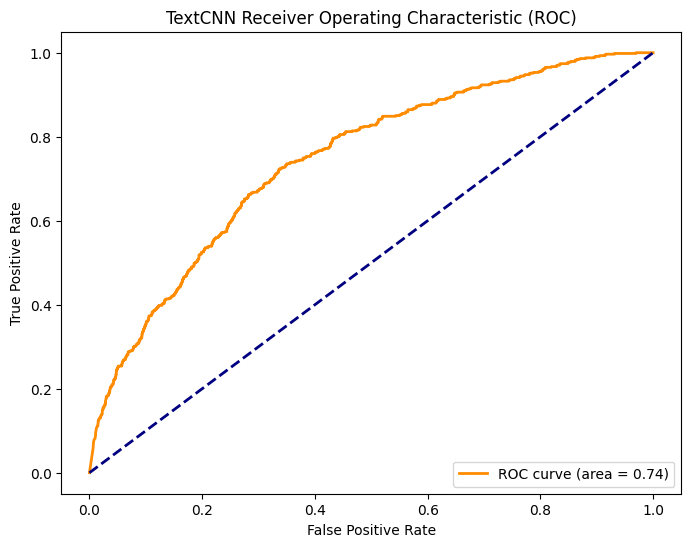

In [13]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('TextCNN Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [14]:
data = {
    'ID': test['subject_id'],
    'Probability': y_pred_probs.ravel(), 
    'Mortality': y_test
}

df = pd.DataFrame(data)

csv_file = 'notes_cnn.csv'
df.to_csv(csv_file, index=False)
print(f"Data saved to {csv_file}")

Data saved to notes_cnn.csv
